In [2]:
# Preload the interleaf data 
import pandas as pd
df = pd.read_csv('/home/ubuntu/LLaVA/playground/data/dpo/dpo_logp.csv')

In [28]:
# Display the image 
IMAGE_FOLDER='/home/ubuntu/train2017'
import matplotlib.pyplot as plt
from PIL import Image
import os

def display(img_filename):
    img_path = os.path.join(IMAGE_FOLDER, img_filename)
    image = Image.open(img_path).convert('RGB')
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [40]:
import torch
import os
import json
import pandas as pd
from tqdm import tqdm
import shortuuid

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, load_image_from_base64, get_model_name_from_path
from llava.train.train import preference_collator_fn
from functools import partial
import tqdm
from llava.train.llava_trainer import get_batch_logps
from PIL import Image
import pandas as pd
import io
from PIL import Image
import base64
import ast
import math
disable_torch_init()
model_path = '/home/ubuntu/LLaVA/checkpoints/llava-v1.5-13b'
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, None, model_name)

use_im_start_end= False # Default setting from llava 1.5 

IMAGE_FOLDER='/home/ubuntu/train2017'
intermediate_csv = '/home/ubuntu/LLaVA/playground/data/dpo/dpo_rlhf_imagepath.csv'
inference_data_path = intermediate_csv
output_path = intermediate_csv.split('csv')[0] + 'with_logp.json'
from llava.train.train import encode_multimodal_preference_sample
import torch.utils.data as torch_data

class PreferenceInferenceDataset(torch_data.Dataset):
    def __init__(self,
                 data_path,
                 tokenizer,
                 img_processor,
                 use_im_start_end):
        self.data = pd.read_csv(data_path)
        columns_toconvert = ['question', 'chosen', 'rejected']
        for col in columns_toconvert:
            self.data[col] = self.data[col].apply(lambda x: ast.literal_eval(x))
        self.mm_cfg = {
            'image_processor': img_processor,
            'is_multimodal': True,
            # 'image_token_len': image_token_len, # TODO check if needed
            'use_im_start_end': use_im_start_end,
            'image_aspect_ratio': 'pad',
            "image_folder": IMAGE_FOLDER,
        }
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        # After encode multimodal preference sample, 
        # the image would ahve the pixel values values
        sample = self.convert_dataframe_row_to_source(self.data.iloc[index])
        rej_data_dict, win_data_dict = encode_multimodal_preference_sample(self.data.iloc[index], self.tokenizer, self.mm_cfg)
        return rej_data_dict, win_data_dict
    
    def _get_image(self, img_filename):
        img_path = os.path.join(IMAGE_FOLDER, img_filename)
        image = Image.open(img_path).convert('RGB')
        return image
    

    def _convert_to_llava_answer_turn(self, answer):
        if isinstance(answer, dict):
            return answer
        return {"from": "gpt", "value": answer}

    def convert_dataframe_row_to_source(self, row):
        dict_output = {'question': row['question'], 
                       # Chosen and rejected based on the sum of the first three quality score
                    'chosen': self._convert_to_llava_answer_turn(row['chosen']),
                    'rejected': self._convert_to_llava_answer_turn(row['rejected']),
                    'image': self._get_image(row['image'])}
        return dict_output

    def __len__(self):
        return len(self.data)
    
preference_torch_dataset = PreferenceInferenceDataset(inference_data_path,
                           tokenizer=tokenizer,
                           img_processor=image_processor,
                           use_im_start_end=False)
preference_torch_dataset[0]

dataset = preference_torch_dataset
collate_fn = partial(preference_collator_fn, pad_token_id=tokenizer.pad_token_id)
dataloader = torch_data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn,
                                    num_workers=5, shuffle=False)
win_logp_list = []
rej_logp_list = []

win_avg_logp_list = []
rej_avg_logp_list = []

win_per_token_logp_list = []
rej_per_token_logp_list = []

with torch.inference_mode():
    for batch in tqdm.tqdm(dataloader):
        for key in ['win', 'rej']:
            input_ids = batch[f'{key}_input_ids'].cuda()
            labels = batch[f'{key}_labels'].cuda()
            attention_mask = batch[f'{key}_attention_mask'].cuda()

            output = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                images=batch['images'].half().cuda()
            )
            per_token_logp, log_prob, average_log_prob = get_batch_logps(output.logits, labels, return_all=True)

            # print(per_token_logp.shape, input_ids.shape, labels.shape, flush=True)
            assert per_token_logp.size(1) >= input_ids.size(1) - 1
            per_token_logp = per_token_logp.tolist()
            # per_token_logp = [x[:input_ids[i].ne(tokenizer.pad_token_id).sum().item()] for i, x in enumerate(per_token_logp)]
            log_prob = log_prob.tolist()
            average_log_prob = average_log_prob.tolist()

            if key == 'win':
                win_logp_list += log_prob
                win_avg_logp_list += average_log_prob
                win_per_token_logp_list += per_token_logp
            else:
                rej_logp_list += log_prob
                rej_avg_logp_list += average_log_prob
                rej_per_token_logp_list += per_token_logp
            # print(f'{key} logits in {output.logits.shape}, logp in {log_prob.shape} avg_logp in {average_log_prob.shape}')

df = pd.read_csv(inference_data_path)

def _convert_to_llava_answer_turn(answer):
    return {"from": "gpt", "value": answer}
# Add each list as a column to the dataframe with its variable name
df['ref_win_logp'] = win_logp_list
df['ref_rej_logp'] = rej_logp_list
df['ref_win_avg_logp'] = win_avg_logp_list
df['ref_rej_avg_logp'] = rej_avg_logp_list
df['ref_win_per_token_logp'] = win_per_token_logp_list
df['ref_rej_per_token_logp'] = rej_per_token_logp_list
columns_toconvert = ['question', 'chosen', 'rejected']
for col in columns_toconvert:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))
# df.to_json(output_path, orient='records')

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


.....Loading vision tower and image processor...


100%|██████████| 1401/1401 [02:45<00:00,  8.48it/s]


In [22]:
import ast

columns_toconvert = ['question', 'chosen', 'rejected']
for col in columns_toconvert:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))

In [24]:
df['chosen'][0]

{'from': 'gpt',
 'value': 'In the image, several baseball players are positioned on the field during a game. A batter is holding a baseball bat and standing next to the home plate, preparing to hit the ball. Behind the batter, a catcher and an umpire are in their respective positions, with the catcher wearing a baseball glove and the umpire closely observing the game. Other players are also present on the field, with one of them holding a baseball bat, indicating that he might be waiting for his turn to bat.\n\nThe arrangement of these players and their equipment creates a dynamic scene that captures the essence of a baseball game. The batter, catcher, and umpire are the main focal points, while the other players contribute to the overall atmosphere of the game. The presence of multiple baseball bats suggests that the game is in progress, and the players are actively engaged in the match.'}

In [25]:
df.to_json('/home/ubuntu/LLaVA/playground/data/dpo/dpo_logp_rlhf1401.json', orient='records')


In [12]:
import pandas as pd
df = pd.read_json('/home/ubuntu/LLaVA/playground/data/dpo/dpo_logp_rlhf1401.json')

In [20]:
df['question'][0]

"{'from': 'human', 'value': '<image>\\nHow do the elements in the image relate to each other in terms of positioning or composition?'}"

In [11]:
df['image'].iloc[0]

'rlhf_v_hall_images/0.jpg'

<Axes: ylabel='Frequency'>

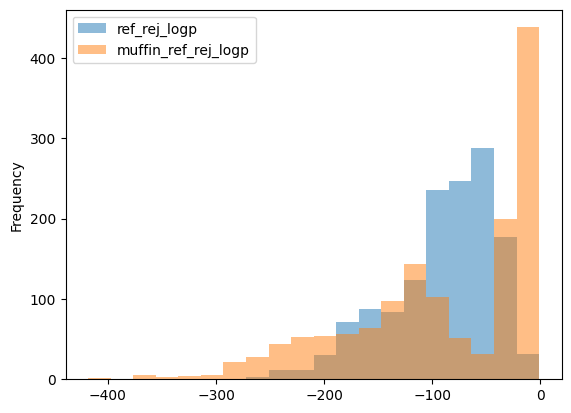

In [42]:
comparison = ['ref_rej_logp', 'muffin_ref_rej_logp']
df[comparison].plot.hist(bins=20, alpha=0.5)

<Axes: ylabel='Frequency'>

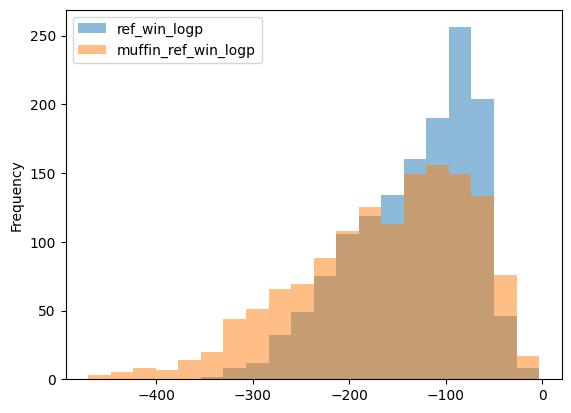

In [41]:
comparison = ['ref_win_logp', 'muffin_ref_win_logp']
df[comparison].plot.hist(bins=20, alpha=0.5)

In [1]:
df['image']

NameError: name 'df' is not defined

In [33]:
import json
import ast
df = pd.read_csv('/home/ubuntu/LLaVA/playground/data/dpo/dpo_rlhf_imagepath.csv')
columns_toconvert = ['question', 'chosen', 'rejected']
for col in columns_toconvert:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))


In [36]:
df['question'][0].dtype

AttributeError: 'dict' object has no attribute 'dtype'

In [30]:
df['question'] = df['question'].astype(lambda: x: json.loads(x))

SyntaxError: invalid syntax (1971771691.py, line 1)

In [11]:
from PIL import Image

# Assuming df['image'].iloc[0] is your image
image = df['image'].iloc[0]

if isinstance(image, Image.Image):
    print("The image is of type PIL.Image.Image")
else:
    print("The image is not of type PIL.Image.Image")

The image is not of type PIL.Image.Image


In [7]:
isinstance(df['image'].iloc[0], str)

True

In [1]:
df[['ref_rej_logp', 'ref_win_logp']].boxplot()
plt.title('llava 1.5 13b PPO based on gpt4v response log p for self-sampled responses')
plt.ylim(-500, 0)
plt.show()


NameError: name 'df' is not defined

In [14]:
def _convert_to_llava_answer_turn(answer):
    return {"from": "gpt", "value": answer}



In [15]:
df_reload['chosen'] = df_reload['chosen'].apply(_convert_to_llava_answer_turn)
df_reload['rejected'] = df_reload['rejected'].apply(_convert_to_llava_answer_turn)

In [17]:
df_reload['rejected']

0       {'from': 'gpt', 'value': 'The dessert in the i...
1       {'from': 'gpt', 'value': 'The player's perform...
2       {'from': 'gpt', 'value': 'The image displays a...
3       {'from': 'gpt', 'value': 'The scenario depicts...
4       {'from': 'gpt', 'value': 'The presence of a la...
                              ...                        
1832    {'from': 'gpt', 'value': 'One possible reason ...
1833    {'from': 'gpt', 'value': 'The cyclist is takin...
1834    {'from': 'gpt', 'value': 'Several aspects of t...
1835    {'from': 'gpt', 'value': 'The image captures a...
1836    {'from': 'gpt', 'value': 'The image presents a...
Name: rejected, Length: 1837, dtype: object

# Old draft below

In [8]:
import torch
import os
import json
import pandas as pd
from tqdm import tqdm
import shortuuid

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, process_images, load_image_from_base64, get_model_name_from_path

from PIL import Image
import math
disable_torch_init()
model_path = '/home/ubuntu/LLaVA/checkpoints/llava-v1.5-13b'
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, None, model_name)

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


.....Loading vision tower and image processor...


In [9]:
use_im_start_end= False # Default setting from llava 1.5 

IMAGE_FOLDER='/home/ubuntu/train2017'


In [10]:
# Inspect previous setup

df_muffin_tsv = '/home/ubuntu/muffin/data/RLHF-V-Hall_v0/RLHF-V-Hall_v0-1837.tsv'
df = pd.read_csv(df_muffin_tsv, sep='\t')

In [11]:
from llava.train.train import encode_multimodal_preference_sample
import torch.utils.data as torch_data

class PreferenceInferenceDataset(torch_data.Dataset):
    def __init__(self,
                 data_path,
                 tokenizer,
                 img_processor,
                 use_im_start_end):
        self.data = pd.read_csv(data_path, sep='\t')

        self.mm_cfg = {
            'image_processor': img_processor,
            'is_multimodal': True,
            # 'image_token_len': image_token_len, # TODO check if needed
            'use_im_start_end': use_im_start_end,
            'image_aspect_ratio': 'pad'
        }
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        # After encode multimodal preference sample, 
        # the image would ahve the pixel values values
        sample = self.convert_dataframe_row_to_source(self.data.iloc[index])
        rej_data_dict, win_data_dict = encode_multimodal_preference_sample(sample, self.tokenizer, self.mm_cfg)
        return rej_data_dict, win_data_dict
    
    def _get_image(self, img_filename):
        img_path = os.path.join(IMAGE_FOLDER, img_filename)
        image = Image.open(img_path).convert('RGB')
        return image
    

    def _convert_to_llava_answer_turn(self, answer):
        return {"from": "gpt", "value": answer}

    def convert_dataframe_row_to_source(self, row):
        dict_output = {'question': row['question'], 
                       # Chosen and rejected based on the sum of the first three quality score
                    'chosen': self._convert_to_llava_answer_turn(row['chosen']),
                    'rejected': self._convert_to_llava_answer_turn(row['rejected']),
                    'image': self._get_image(row['image'])}
        return dict_output

    def __len__(self):
        return len(self.data)
    
preference_torch_dataset = PreferenceInferenceDataset('/home/ubuntu/muffin/data/RLHF-V-Hall_v0/RLHF-V-Hall_v0-1837.tsv',
                           tokenizer=tokenizer,
                           img_processor=image_processor,
                           use_im_start_end=False)
preference_torch_dataset[0]

({'input_ids': tensor([    1,   319, 13563,  1546,   263, 12758,  1404,   322,   385, 23116,
          21082, 20255, 29889,   450, 20255,  4076,  8444, 29892, 13173, 29892,
            322,  1248,   568,  6089,   304,   278,  1404, 29915, 29879,  5155,
          29889,  3148,  1001, 29901,   529,  3027, 29958,    13, 11008,   338,
            445,  6808,   814,  5929, 12818,   304,  4856,   411,   263, 14225,
            304,   720, 29973,   319,  1799,  9047, 13566, 29901,   450,  6808,
            814,   297,   278,  1967, 29892,   607,  5680,   263,  8424,   310,
            274,  1296, 10664,   297,   377, 16242,   907,   314,   322,   521,
            542, 23167,   528,   485,   886, 29892,   723,   367, 10712,  5929,
          12818,   304,  4856,   411,   263, 14225,   304,   720, 29889,   910,
            338,  1363,   278,   274,  1296,  3528,  5692,   304,   367,   263,
           8261,   322, 29156,  5362,  7539, 29892,  1754,  1584,   901,   875,
          18499,   491,   2

In [12]:
preference_torch_dataset.mm_cfg['image_aspect_ratio']

'pad'

In [13]:
def _convert_to_llava_answer_turn(self, answer):
    return {"from": "gpt", "value": answer}

torch.Size([3, 336, 336])

In [14]:
preference_torch_dataset[0][0]['input_ids'].shape

torch.Size([226])

In [ ]:
from llava.train.train import preference_collator_fn
from functools import partial
import tqdm
from llava.train.llava_trainer import get_batch_logps
dataset = preference_torch_dataset
collate_fn = partial(preference_collator_fn, pad_token_id=tokenizer.pad_token_id)
dataloader = torch_data.DataLoader(dataset, batch_size=1, collate_fn=collate_fn,
                                    num_workers=5, shuffle=False)
win_logp_list = []
rej_logp_list = []

win_avg_logp_list = []
rej_avg_logp_list = []

win_per_token_logp_list = []
rej_per_token_logp_list = []

with torch.inference_mode():
    for batch in tqdm.tqdm(dataloader):
        for key in ['win', 'rej']:
            input_ids = batch[f'{key}_input_ids'].cuda()
            labels = batch[f'{key}_labels'].cuda()
            attention_mask = batch[f'{key}_attention_mask'].cuda()

            output = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                images=batch['images'].half().cuda()
            )
            per_token_logp, log_prob, average_log_prob = get_batch_logps(output.logits, labels, return_all=True)

            # print(per_token_logp.shape, input_ids.shape, labels.shape, flush=True)
            assert per_token_logp.size(1) >= input_ids.size(1) - 1
            per_token_logp = per_token_logp.tolist()
            # per_token_logp = [x[:input_ids[i].ne(tokenizer.pad_token_id).sum().item()] for i, x in enumerate(per_token_logp)]
            log_prob = log_prob.tolist()
            average_log_prob = average_log_prob.tolist()

            if key == 'win':
                win_logp_list += log_prob
                win_avg_logp_list += average_log_prob
                win_per_token_logp_list += per_token_logp
            else:
                rej_logp_list += log_prob
                rej_avg_logp_list += average_log_prob
                rej_per_token_logp_list += per_token_logp
            # print(f'{key} logits in {output.logits.shape}, logp in {log_prob.shape} avg_logp in {average_log_prob.shape}')

In [14]:
next(iter(dataloader))

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/transformers/feature_extraction_utils.py", line 92, in __getattr__
    return self.data[item]
KeyError: 'shape'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 808, in preference_collator_fn
    rej_batch = SFT_collator_fn(rej_instances, pad_token_id)
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 789, in SFT_collator_fn
    if all(x is not None and x.shape == images[0].shape for x in images):
  File "/home/ubuntu/LLaVA/llava/train/train.py", line 789, in <genexpr>
    if all(x is not None and x.shape == images[0].shape for x in images):
  File "/home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/transformers/feature_extraction_utils.py", line 94, in __getattr__
    raise AttributeError
AttributeError


In [15]:
%debug

> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/_utils.py(644)reraise()
    642             # instantiate since we don't know how to
    643             raise RuntimeError(msg) from None
--> 644         raise exception
    645 
    646 

*** NameError: name 'images' is not defined
> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/dataloader.py(1371)_process_data()
   1369         self._try_put_index()
   1370         if isinstance(data, ExceptionWrapper):
-> 1371             data.reraise()
   1372         return data
   1373 

*** NameError: name 'images' is not defined
*** Invalid frame count (')
> /home/ubuntu/mambaforge-pypy3/envs/llava/lib/python3.10/site-packages/torch/utils/data/dataloader.py(1345)_next_data()
   1343             else:
   1344                 del self._task_info[idx]
-> 1345                 return self._process_data(data)
   1346 
   1347     def _try_put_index(self):

> /home/ubuntu/mambaforge-